# 🧠 Modeling

In [18]:
# Use the same kernal with Step 1
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA

## Choosing suitable parameters

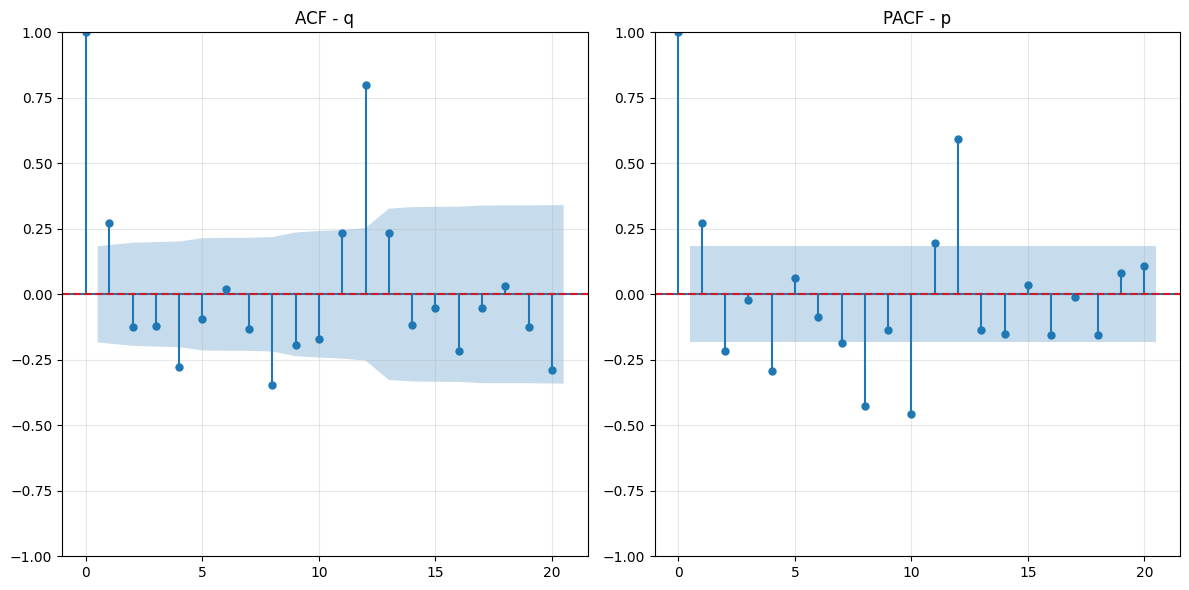

In [19]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
plot_acf(y_train_diff, lags=20, alpha=0.05, ax=ax1, title='ACF - q')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax1.grid(True, alpha=0.3)

# Plot 2
plot_pacf(y_train_diff, lags=20, alpha=0.05, ax=ax2, title='PACF - p')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax2.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

Suggested parameters: p = 8, q = 8

In [20]:
# Automatic p and q selection based on ACF/PACF
def select_arima_params(series, alpha):
    """Automatically select p and q based on ACF/PACF"""
    acf_vals, acf_conf = acf(series, nlags=20, alpha=alpha, fft=False)
    pacf_vals, pacf_conf = pacf(series, nlags=20, alpha=alpha)
    
    # Find significant lags (outside confidence interval)
    n = len(series.dropna())
    critical_value = 1.645 / np.sqrt(n)  # For alpha
    
    significant_p = []
    significant_q = []
    
    for lag in range(1, min(11, len(acf_vals))):
        if abs(acf_vals[lag]) > critical_value:
            significant_q.append(lag)
        if abs(pacf_vals[lag]) > critical_value:
            significant_p.append(lag)
    
    p = max(significant_p) if significant_p else 0
    q = max(significant_q) if significant_q else 0
    
    return p, q, significant_p, significant_q

# Use the function
p, q, sig_p, sig_q = select_arima_params(y_train_diff, alpha=0.05)
print(f"Suggested parameters: p = {p}, q = {q}")
print(f"Significant PACF lags: {sig_p}")
print(f"Significant ACF lags: {sig_q}")

Suggested parameters: p = 10, q = 10
Significant PACF lags: [1, 2, 4, 7, 8, 9, 10]
Significant ACF lags: [1, 4, 8, 9, 10]


In [21]:
model = pm.auto_arima(y_train_diff, start_p=1, start_q=1, max_p=10, max_q=10, d=0, seasonal=True, stepwise=False, trace=True, information_criterion='bic')
print(model.summary())

 ARIMA(0,0,0)(0,0,0)[1] intercept   : BIC=1081.991, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : BIC=1072.833, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : BIC=1072.023, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : BIC=1077.649, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : BIC=1069.779, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : BIC=1077.147, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : BIC=1081.775, Tim

## Training data

In [22]:
# Define ARMA model
# ARMA(p, q) means:
# - p = order of AR (AutoRegressive part)
# - q = order of MA (Moving Average part)
p, q = 8, 8
model = ARIMA(y_train_diff, order=(p, 0, q))  
# Note: order = (p, d, q), here d=0 because we already differenced

In [23]:
print("p =", p, ", q =", q)

p = 8 , q = 8


In [24]:
# Fit the model
arma = model.fit()

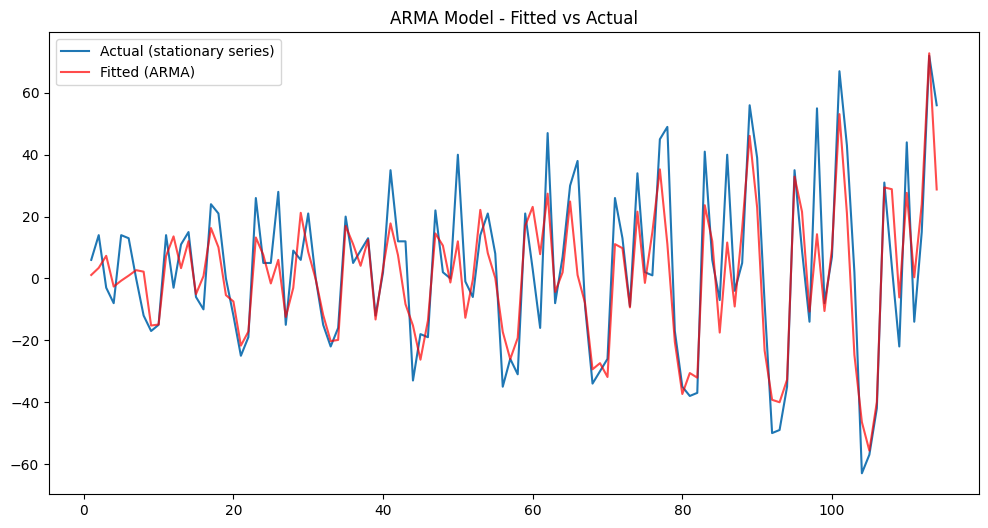

In [25]:
# Plot fitted values vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff, label="Actual (stationary series)")
plt.plot(arma.fittedvalues, color='red', alpha=0.7, label="Fitted (ARMA)")
plt.title("ARMA Model - Fitted vs Actual")
plt.legend()
plt.show()

In [26]:
train_size = len(data_train)

# Forecast the differenced values on the test set
y_pred_diff_test = arma.predict(start=train_size, end=len(df)-1)

# Take the last original value from the training set (anchor for cumulative sum)
last_actual = df[target].iloc[train_size - 1]

# Convert predictions back to the original scale by cumulative sum + last known value
y_pred = y_pred_diff_test.cumsum() + last_actual

In [27]:
# Size checking
print(f"Length of test dates: {len(df['date'][train_size:])}")
print(f"Length of predicted values: {len(y_pred)}")

Length of test dates: 29
Length of predicted values: 29


In [28]:
y_pred_diff_train = arma.predict(start=1, end=train_size-1)
print(len(y_pred_diff_train))
print(len(y_train_diff))

114
114


In [29]:
#for i, j in zip(y_train_diff[target], y_pred_diff_train):
#    print("y_train_diff: {} - y_pred_diff_train: {}".format(i, j))

In [30]:
# Assume y_pred is already the forecast for the test set (no plotting needed)

# Calculate residuals from training differences minus the corresponding training predictions
residuals = y_train_diff[target] - y_pred_diff_train

# Compute the standard deviation of residuals (used to estimate forecast uncertainty)
sigma = np.std(residuals)

# Compute 80% and 95% confidence intervals for the predictions
lo_80 = y_pred - 1.28 * sigma   # lower bound for 80% CI
hi_80 = y_pred + 1.28 * sigma   # upper bound for 80% CI
lo_95 = y_pred - 1.96 * sigma   # lower bound for 95% CI
hi_95 = y_pred + 1.96 * sigma   # upper bound for 95% CI

# Check the results
# print(y_pred_test[:5])  # first 5 predicted values
print(lo_80[:5])        # first 5 lower bounds of 80% CI
print(hi_80[:5])        # first 5 upper bounds of 80% CI


115    405.011634
116    347.669428
117    294.337263
118    316.895379
119    334.858972
Name: predicted_mean, dtype: float64
115    480.688102
116    423.345897
117    370.013731
118    392.571847
119    410.535441
Name: predicted_mean, dtype: float64


## Actual vs Prediction

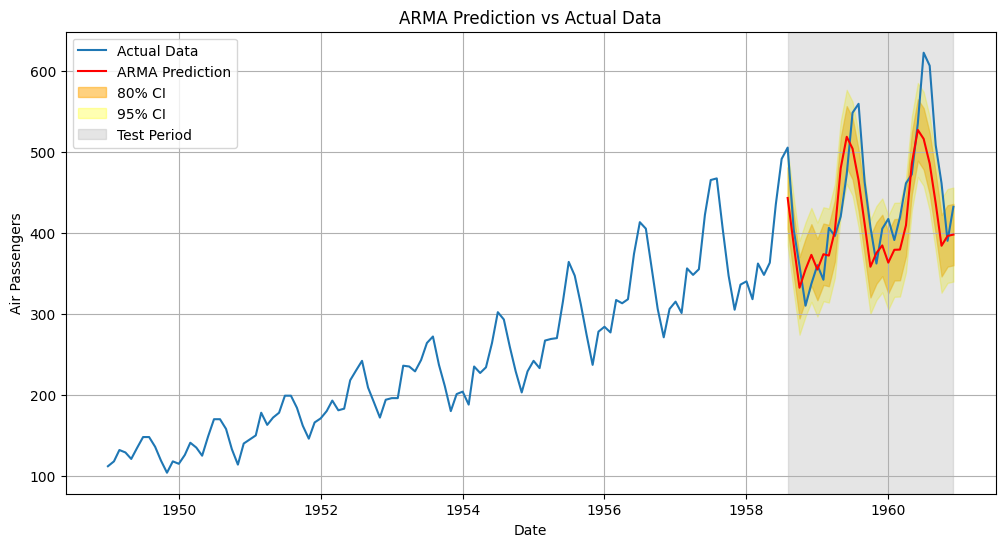

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot the entire actual data
ax.plot(df["date"], df[target], label="Actual Data")

# Plot the prediction on the test set in red
ax.plot(df["date"][train_size:], y_pred, label="ARMA Prediction", color="red")

# Confidence Intervals
ax.fill_between(df["date"][train_size:], lo_80, hi_80, color='orange', alpha=0.5, label="80% CI")
ax.fill_between(df["date"][train_size:], lo_95, hi_95, color='yellow', alpha=0.3, label="95% CI")


# Highlight the test period for better visualization (gray background)
ax.axvspan(df["date"].iloc[train_size], df["date"].iloc[-1], color='gray', alpha=0.2, label="Test Period")

ax.set_title("ARMA Prediction vs Actual Data")
ax.set_xlabel("Date")
ax.set_ylabel(target_name_for_plot)
ax.legend()
ax.grid(True)
plt.show()


In [32]:
print(len(y_test))
print(len(y_pred))

29
29


In [33]:
for i, j in zip(y_pred, y_test):
    print("Prediction: {} - Actual: {}".format(i, j))

Prediction: 442.84986803972873 - Actual: 505
Prediction: 385.50766273079256 - Actual: 404
Prediction: 332.1754970741343 - Actual: 359
Prediction: 354.73361305269486 - Actual: 310
Prediction: 372.6972062032039 - Actual: 337
Prediction: 354.59862030719523 - Actual: 360
Prediction: 373.4685699846424 - Actual: 342
Prediction: 371.8337932966162 - Actual: 406
Prediction: 402.3086711748167 - Actual: 396
Prediction: 479.50459924291505 - Actual: 420
Prediction: 518.2915362991022 - Actual: 472
Prediction: 503.74209047114414 - Actual: 548
Prediction: 464.6336854037332 - Actual: 559
Prediction: 411.22896639985083 - Actual: 463
Prediction: 358.04501243366815 - Actual: 407
Prediction: 375.0244893835519 - Actual: 362
Prediction: 384.33093836407295 - Actual: 405
Prediction: 363.13565983148226 - Actual: 417
Prediction: 378.91923970657786 - Actual: 391
Prediction: 379.21461447442886 - Actual: 419
Prediction: 409.17754665632043 - Actual: 461
Prediction: 485.38383942166377 - Actual: 472
Prediction: 526.73